In [40]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from prettytable import PrettyTable
from sklearn.naive_bayes import BernoulliNB,GaussianNB,MultinomialNB

# Import Data

In [0]:
import pandas as pd
final = pd.read_csv("final.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(142897) #Gets 1000 reviews of positive and negative scores
neg_2000 = neg.sample(57103)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (200000, 11)


Observations:
We choose 142897 positive and 57103 negative reviews from the final dataframe obtained after data cleaning process.

In [0]:
import datetime
grouped_data['Time'] = grouped_data['Time'].map(lambda a: datetime.datetime.fromtimestamp(int(a)).strftime('%Y-%m-%d %H:%M:%S'))
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores = grouped_data['Score']
print("The shape of grouped data after time based splitting is {}".format(grouped_data.shape))

The shape of grouped data after time based splitting is (200000, 11)


Observations:
Time based splitting is done on the obtained dataframe.

In [0]:
grouped_data.to_csv("grouped_data_200")

Observations:
Saving this dataframe into a new csv file.

# Utility Functions

In [27]:
#We create a few utility functions whose use is described below


def optimala_bayes(x_train,y_train,x_test,y_test,x_cv,y_cv): #This function implements Naive Bayes finds and plots confusion matrix for optimal alpha.
    my_cv = TimeSeriesSplit(n_splits=2).split(x_train)
    parameters = {'alpha' : [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}
    model = MultinomialNB()
    gsearch = GridSearchCV(estimator = model, param_grid = parameters,cv=my_cv)
    gsearch.fit(x_train,y_train)
    a = gsearch.best_params_
    print("The optimal alpha value found is",gsearch.best_params_)
    nb = gsearch.best_estimator_
    
    '''
    Find train and test accuracy
    '''
    nb.fit(x_train, y_train) # Fitting the model
    predt = nb.predict(x_cv)
    print('\nThe train accuracy of naive bayes for alpha = %d is %f%%' % (gsearch.best_params_['alpha'], accuracy_score(y_cv, predt) * 100))
    print('\nThe train precision of naive bayes for alpha = %d is %f%%' % (gsearch.best_params_['alpha'], precision_score(y_cv,predt,pos_label='Positive')*100))
    print('\nThe train recall of naive bayes for alpha = %d is %f%%' % (gsearch.best_params_['alpha'], recall_score(y_cv,predt,pos_label='Positive')*100))
    print('\nThe train f1 score of naive bayes for alpha = %d is %f%%' % (gsearch.best_params_['alpha'], f1_score(y_cv,predt,pos_label='Positive')*100))
    print("*"*50)
    pred = nb.predict(x_test) # Predict the response
    print('\nThe test accuracy of naive bayes for alpha = %d is %f%%' % (gsearch.best_params_['alpha'], accuracy_score(y_test, pred) * 100))
    print('\nThe test precision of naive bayes for alpha = %d is %f%%' % (gsearch.best_params_['alpha'], precision_score(y_test,pred,pos_label='Positive')*100))
    print('\nThe test recall of naive bayes for alpha = %d is %f%%' % (gsearch.best_params_['alpha'], recall_score(y_test,pred,pos_label='Positive')*100))
    print('\nThe test f1 score of naive bayes for alpha = %d is %f%%' % (gsearch.best_params_['alpha'], f1_score(y_test,pred,pos_label='Positive')*100))
    print("*"*50)
    '''
    Classification report
    '''
    print(classification_report(y_test,pred))
    print("*"*50)
    
    '''
    Plot confusion matrix
    '''
    y_true = np.array(y_test)
    y_pred = np.array(pred)
    labels = ['Negative','Positive']
    print(confusion_matrix(y_test, pred))
    cm = ConfusionMatrix(np.where(y_true == 'Positive', True, False), np.where(y_pred == 'Negative',False, True)) #This the confusion matrix of pandas_ml which provides interesting stats.
    confusion_matrix_plot = confusion_matrix(y_test,pred) #We are plotting confusion matrix of sklearn
    heatmap = sns.heatmap(confusion_matrix_plot, annot=True,cmap='Blues', fmt='g',xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'])
    plt.title('Confusion matrix of the classifier')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("*"*50)
    print("The True Positive Rate observed is",cm.TPR) #This prints the True Positive Rate of the confusion matrix (using pandas_ml confusion matrix).
    print("The True Negative Rate observed is",cm.TNR)
    print("The False Positive Rate observed is",cm.FPR)
    print("The False Negative Rate observed is",cm.FNR)
    print("*"*50)
    print("The stats observed for confusion matrix are:")
    cm.print_stats()#Prints all the stats of the confusion matrix plotted (using pandas_ml confusion matrix).
    
def get_top_feats(feats, alpha, x_train, y_train): #This function gets the top features from Naive Bayes
    print("Total number of words detected are", len(feats))
    count_vect = CountVectorizer() #Initialise count vectorizer
    vocab = count_vect.fit(x_train['CleanedText'].values) #Fit the entire dataset
    data_train = count_vect.transform(x_train['CleanedText'].values) #Vector form of all the Cleaned text
    data_feat = count_vect.transform(feats) #Vector form of all the words
    standard_feat = StandardScaler(with_mean=False).fit_transform(data_train) #Standardize data
    standard_feat = StandardScaler(with_mean=False).fit_transform(data_feat)
    nb = MultinomialNB(alpha = alpha) #Multinomial naive bayes model
    nb.fit(data_train, y_train)
    pro = nb.predict_log_proba(standard_feat) #Outputs the log probabilities and returns a 2D array
    pos, neg = pro[:,0],pro[:,1] #Split the 2D array into two 1D arrays
    df = pd.DataFrame({'Words': feats, 'P(xi|y=0)':neg, 'P(xi|y=1)':pos}) #Create a dataframe
    print('*'*50,'Completed','*'*50)
    return df

**Observations:**

1) The first function finds the optimal alpha value, plots confusion matrix and lists all of its stats.

2) Another function returns a dataframe with all the words and their probabilites of occurances in both positive and negative reviews.

# Feature Importance

In [9]:
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
scores = grouped_data['Score']
count_vect = CountVectorizer()
vocab = count_vect.fit(grouped_data['CleanedText'].values) #Only the whole data is fit.
features = count_vect.get_feature_names() #Gets the words present in the dataframe.
print('Some unique sample features are ', features[1500:1510])
print('The number of words available are', len(features))

Some unique sample features are  ['ambianc', 'ambien', 'ambient', 'ambigu', 'ambit', 'ambiti', 'ambival', 'ambo', 'ambootia', 'ambrosi']
The number of words available are 53788


Observations: There are a few Nan valued data in the dataset. Also there are a few indexes missing. All these are resolved and all the words are obtained.

In [28]:
df = get_top_feats(features, 1000, grouped_data, scores)

Total number of words detected are 53788
************************************************** Completed **************************************************


Observations: A dataframe is created with all the words and their probabilities.

In [29]:
df.sort_values(['P(xi|y=1)'], ascending=True).head(7)

,Words,P(xi|y=0),P(xi|y=1)
20216,great,0.0,-443.108093
12302,delici,0.0,-429.186481
35046,perfect,0.0,-421.751188
4394,best,0.0,-398.661843
14475,easi,0.0,-376.914328
27549,love,0.0,-376.441001
16720,favorit,0.0,-368.915996


Observations: Top 7 best words for positive reviews are 'great','delici','perfect','best','easi','love','favorit'.

In [30]:
df.sort_values(['P(xi|y=0)'], ascending=True).head(7)

,Words,P(xi|y=0),P(xi|y=1)
39573,return,-232.172029,0.0
52776,worst,-214.890586,0.0
3144,aw,-195.228404,0.0
38961,refund,-192.108306,0.0
22333,horribl,-190.111769,0.0
13200,disappoint,-183.896113,0.0
47519,threw,-178.573280,0.0


Observations: Top 7 best words for negative reviews are 'return','worst','aw','refund','horribl','disappoint','threw'.

# Bag of Words

In [4]:
import pandas as pd
grouped_data = pd.read_csv("grouped_data_200.csv")
scores = grouped_data['Score']
print("The shape of grouped data after time based splitting is {}".format(grouped_data.shape))

The shape of grouped data after time based splitting is (200000, 12)


Observations:
A csv file is imported which consists of 200000 data points. These data points are already sorted on the basis of time.

In [0]:
x_1, x_test, y_1, y_test = cross_validation.train_test_split(grouped_data, scores, test_size=0.3, random_state=0)
x_train, x_cv, y_train, y_cv = cross_validation.train_test_split(x_1, y_1, test_size=0.3)

Observations:
The data is split into train, test and cross validate.

In [23]:
count_vect = CountVectorizer()
vocab = count_vect.fit(x_train['CleanedText'].values.astype('U'))
data_train = count_vect.transform(x_train['CleanedText'].values.astype('U'))
data_test = count_vect.transform(x_test['CleanedText'].values.astype('U'))
data_cv = count_vect.transform(x_cv['CleanedText'].values.astype('U'))
print("The shape of train data for BOW is {}".format(data_train.shape))
print("The shape of test data for BOW is {}".format(data_test.shape))
print("The shape of cv data for BOW is {}".format(data_cv.shape))

The shape of train data for BOW is (98000, 38078)
The shape of test data for BOW is (60000, 38078)
The shape of cv data for BOW is (42000, 38078)


Observations:
We build out Bag of words vocabulary only on train data and get vectors of train and test data.

In [24]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
standard_train = StandardScaler(with_mean=False).fit_transform(data_train)
standard_test = StandardScaler(with_mean=False).fit_transform(data_test)
standard_cv = StandardScaler(with_mean=False).fit_transform(data_cv)
print("The type of standard_train is ",type(data_train))
print("The type of standard_test is ",type(data_test))
print("The shape of standard_train is ",standard_train.get_shape())
print("The shape of standard_test is ",standard_test.get_shape())
print("The shape of standard_cv is ",standard_cv.get_shape())

The type of standard_train is  <class 'scipy.sparse.csr.csr_matrix'>
The type of standard_test is  <class 'scipy.sparse.csr.csr_matrix'>
The shape of standard_train is  (98000, 38078)
The shape of standard_test is  (60000, 38078)
The shape of standard_cv is  (42000, 38078)


Observations: The data is standardized.

The optimal alpha value found is {'alpha': 100}

The train accuracy of naive bayes for alpha = 100 is 80.595238%

The train precision of naive bayes for alpha = 100 is 85.858419%

The train recall of naive bayes for alpha = 100 is 87.087388%

The train f1 score of naive bayes for alpha = 100 is 86.468537%
**************************************************

The accuracy of naive bayes for alpha = 100 is 80.826667%

The precision of naive bayes for alpha = 100 is 86.014147%

The recall of naive bayes for alpha = 100 is 87.293347%

The f1 score of naive bayes for alpha = 100 is 86.649026%
**************************************************
             precision    recall  f1-score   support

   Negative       0.67      0.65      0.66     17235
   Positive       0.86      0.87      0.87     42765

avg / total       0.81      0.81      0.81     60000

**************************************************
[[11165  6070]
 [ 5434 37331]]


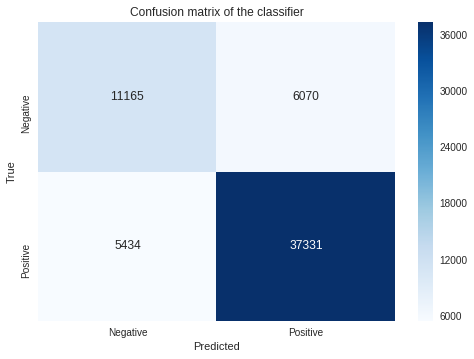

**************************************************
The True Positive Rate observed is 0.8729334736349819
The True Negative Rate observed is 0.6478096895851465
The False Positive Rate observed is 0.3521903104148535
The False Negative Rate observed is 0.1270665263650181
**************************************************
The stats observed for confusion matrix are:
population: 60000
P: 42765
N: 17235
PositiveTest: 43401
NegativeTest: 16599
TP: 37331
TN: 11165
FP: 6070
FN: 5434
TPR: 0.8729334736349819
TNR: 0.6478096895851465
PPV: 0.8601414713946683
NPV: 0.6726308813783963
FPR: 0.3521903104148535
FDR: 0.13985852860533168
FNR: 0.1270665263650181
ACC: 0.8082666666666667
F1_score: 0.866490262980758
MCC: 0.5267234191293148
informedness: 0.5207431632201285
markedness: 0.5327723527730646
prevalence: 0.71275
LRP: 2.4785845828828523
LRN: 0.1961479249351623
DOR: 12.636302850015676
FOR: 0.3273691186216037


In [25]:
optimala_bayes(standard_train, y_train, standard_test, y_test, standard_cv, y_cv)

# TFIDF

In [33]:
import pandas as pd
grouped_data = pd.read_csv("grouped_data.csv")
scores = grouped_data['Score']
print("The shape of grouped data after time based splitting is {}".format(grouped_data.shape))

The shape of grouped data after time based splitting is (50000, 12)


Observations:
A csv file is imported which consists of 50000 data points. These data points are already sorted on the basis of time.

In [34]:
x_1, x_test, y_1, y_test = cross_validation.train_test_split(grouped_data, scores, test_size=0.3, random_state=0)
x_train, x_cv, y_train, y_cv = cross_validation.train_test_split(x_1, y_1, test_size=0.3)

Observations: Data is split into train, test and cross validate

In [36]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocab_tf_idf = tf_idf_vect.fit(x_train['CleanedText'].values) #Converts to a sparse matrix of TF-IDF vectors.
train_tf_idf = tf_idf_vect.transform(x_train['CleanedText'].values)
test_tf_idf = tf_idf_vect.transform(x_test['CleanedText'].values)
cv_tf_idf = tf_idf_vect.transform(x_cv['CleanedText'].values)
print("the type of count vectorizer ",type(train_tf_idf))
print("The shape of train_tf_idf ",train_tf_idf.get_shape())
print("The shape of test_tf_idf ", test_tf_idf.get_shape())
print("The shape of cv_tf_idf ", cv_tf_idf.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train_tf_idf  (24500, 479756)
The shape of test_tf_idf  (15000, 479756)
The shape of cv_tf_idf  (10500, 479756)


Observations:
Vocabulary of TF-IDF is trained for train data and vectors for train and test data are obtained.

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
standardized_train = StandardScaler(with_mean=False).fit_transform(train_tf_idf) #It gets the mean, variance and performs standardization.
standardized_test = StandardScaler(with_mean=False).fit_transform(test_tf_idf)
standardized_cv = StandardScaler(with_mean=False).fit_transform(cv_tf_idf)
print("The shape of standardized train data is",standardized_train.shape)
print("The shape of standardized test data is",standardized_test.shape)
print("The shape of standardized cv data is",standardized_cv.shape)

The shape of standardized train data is (24500, 479756)
The shape of standardized test data is (15000, 479756)
The shape of standardized cv data is (10500, 479756)


Observations:
Data is standardized.

The optimal alpha value found is {'alpha': 1000}

The train accuracy of naive bayes for alpha = 1000 is 82.761905%

The train precision of naive bayes for alpha = 1000 is 79.665294%

The train recall of naive bayes for alpha = 1000 is 95.555202%

The train f1 score of naive bayes for alpha = 1000 is 86.889758%
**************************************************

The test accuracy of naive bayes for alpha = 1000 is 82.946667%

The test precision of naive bayes for alpha = 1000 is 79.970035%

The test recall of naive bayes for alpha = 1000 is 95.323139%

The test f1 score of naive bayes for alpha = 1000 is 86.974234%
**************************************************
             precision    recall  f1-score   support

   Negative       0.90      0.65      0.75      6041
   Positive       0.80      0.95      0.87      8959

avg / total       0.84      0.83      0.82     15000

**************************************************
[[3902 2139]
 [ 419 8540]]


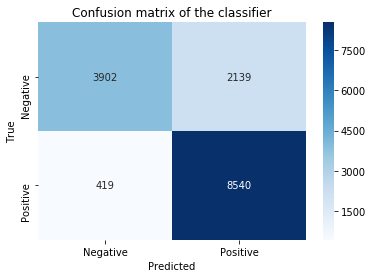

**************************************************
The True Positive Rate observed is 0.953231387431633
The True Negative Rate observed is 0.6459195497434199
The False Positive Rate observed is 0.35408045025658
The False Negative Rate observed is 0.04676861256836701
**************************************************
The stats observed for confusion matrix are:
population: 15000
P: 8959
N: 6041
PositiveTest: 10679
NegativeTest: 4321
TP: 8540
TN: 3902
FP: 2139
FN: 419
TPR: 0.953231387431633
TNR: 0.6459195497434199
PPV: 0.799700346474389
NPV: 0.9030317056236982
FPR: 0.35408045025658
FDR: 0.20029965352561102
FNR: 0.04676861256836701
ACC: 0.8294666666666667
F1_score: 0.8697423362867909
MCC: 0.648877929658204
informedness: 0.599150937175053
markedness: 0.7027320520980873
prevalence: 0.5972666666666666
LRP: 2.6921322166781185
LRN: 0.07240625026281525
DOR: 37.18093682391232
FOR: 0.09696829437630178


In [38]:
optimala_bayes(standardized_train,y_train,standardized_test,y_test,standardized_cv,y_cv)

# Conclusion

In [39]:
x = PrettyTable()
x.field_names = ["Model", "Hyper Parameter", "Test Accuracy","Precision","Recall","F1 Score"]
x.add_row(["Bag of Words","alpha = 1000","80.82%", "86.01%", "87.29%", "86.65%"])
x.add_row(["","","","","",""])
x.add_row(["TF-IDF","alpha = 1000","82.95%", "79.97%", "95.32%", "86.97%"])
print(x.get_string())
print('*'*120)

y = PrettyTable()
y.field_names = ["Model", "Hyper Parameter", "TPR", "TNR", "FPR", "FNR"]
y.add_row(["Bag of Words","alpha = 1000","95.07%","54.99%","45.00%","4.92%"])
y.add_row(["","","","","",""])
y.add_row(["TF-IDF","alpha = 1000","87.29%", "64.78%", "35.22%", "12.71%"])
print(y.get_string())
print('*'*120)

z = PrettyTable()
z.field_names = ["Words with higer probability for positive reviews","Words with higer probability for negative reviews"]
z.add_row(["great","return"])
z.add_row(["",""])
z.add_row(["delci","worst"])
z.add_row(["",""])
z.add_row(["perfect","aw"])
z.add_row(["",""])
z.add_row(["best","refund"])
z.add_row(["",""])
z.add_row(["easi","horribl"])
z.add_row(["",""])
z.add_row(["love","disappoint"])
z.add_row(["",""])
z.add_row(["favorit","threw"])
print(z.get_string())

+--------------+-----------------+---------------+-----------+--------+----------+
|    Model     | Hyper Parameter | Test Accuracy | Precision | Recall | F1 Score |
+--------------+-----------------+---------------+-----------+--------+----------+
| Bag of Words |   alpha = 1000  |     80.82%    |   86.01%  | 87.29% |  86.65%  |
|              |                 |               |           |        |          |
|    TF-IDF    |   alpha = 1000  |     82.95%    |   79.97%  | 95.32% |  86.97%  |
+--------------+-----------------+---------------+-----------+--------+----------+
************************************************************************************************************************
+--------------+-----------------+--------+--------+--------+--------+
|    Model     | Hyper Parameter |  TPR   |  TNR   |  FPR   |  FNR   |
+--------------+-----------------+--------+--------+--------+--------+
| Bag of Words |   alpha = 1000  | 95.07% | 54.99% | 45.00% | 4.92%  |
|             